# LSTM for streamflow prediction

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch import nn
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# tutorial used for inspiration: https://www.crosstab.io/articles/time-series-pytorch-lstm

# Define input variables, define input data into Pandas DataFrame and normalize data

In [ ]:
# define target dataset to predict and other variables for model
target = 'target'
sequence_length = 365
batch_size =  512
learning_rate = 0.1
num_hidden_units = 20
epochs = 50
epochs_to_save = [1, 2, 3, 5, 10, 50]

train_start = '1980-10-01' # starts 1 year later due to padding in figure
train_end = '1995-09-30'

# for reproducibility figure
test_start = '1982-10-01' # starts 1 year later due to padding in figure
test_end = '1986-09-30'

# for prediction plot in training data
start_prediction = '1995-10-01' # starts 1 year later due to padding in figure
end_prediction = '2000-09-30'


In [ ]:
# load entire dataset into pandas
# df = pd.read_csv('https://drive.google.com/uc?export=download&id=1QTFvucJpQfMwBQTkl3VZzQtFeuSXyd9P', index_col='date',)
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1zikXtFD8oePhBKIgbWYsmKRuFqCzRpxm', index_col='date',)

# drop empty column
df = df.drop(columns='Unnamed: 0.1')
df = df.drop(columns='Unnamed: 0')
print(df)
# convert -999 (no data) to 0
df[target][df[target]==-999] = 0


                 prcp       tmax       tmin          vp        srad    target
date                                                                         
1980-01-01   7.719036   2.635163  -7.404501  356.909575  108.665846    0.4296
1980-01-02   3.660781   2.484138  -7.616933  350.118484  123.689874    0.4560
1980-01-03   4.320509   0.016926  -5.137492  418.422967   74.293477    0.4720
1980-01-04  13.075693  -1.130720 -15.443935  194.276939  143.881449    0.4192
1980-01-05  15.739118   0.715120 -10.464246  281.074570  125.166372    0.4752
...               ...        ...        ...         ...         ...       ...
2014-12-27  14.423401  -3.103501  -6.586893  375.666898   71.825399 -999.0000
2014-12-28  10.665780  -2.270882  -8.514715  328.833729  112.132569 -999.0000
2014-12-29   0.000000  -8.595164 -19.983440  131.992812  202.927692 -999.0000
2014-12-30   0.000000 -11.541329 -23.285177   97.067639  205.219366 -999.0000
2014-12-31   0.000000  -6.640727 -17.153745  159.996260  199.403

In [ ]:
df

,prcp,tmax,tmin,vp,srad,target
date,,,,,,
1980-01-01,7.719036,2.635163,-7.404501,356.909575,108.665846,0.4296
1980-01-02,3.660781,2.484138,-7.616933,350.118484,123.689874,0.4560
1980-01-03,4.320509,0.016926,-5.137492,418.422967,74.293477,0.4720
1980-01-04,13.075693,-1.130720,-15.443935,194.276939,143.881449,0.4192
1980-01-05,15.739118,0.715120,-10.464246,281.074570,125.166372,0.4752
...,...,...,...,...,...,...
2014-12-27,14.423401,-3.103501,-6.586893,375.666898,71.825399,0.0000
2014-12-28,10.665780,-2.270882,-8.514715,328.833729,112.132569,0.0000
2014-12-29,0.000000,-8.595164,-19.983440,131.992812,202.927692,0.0000


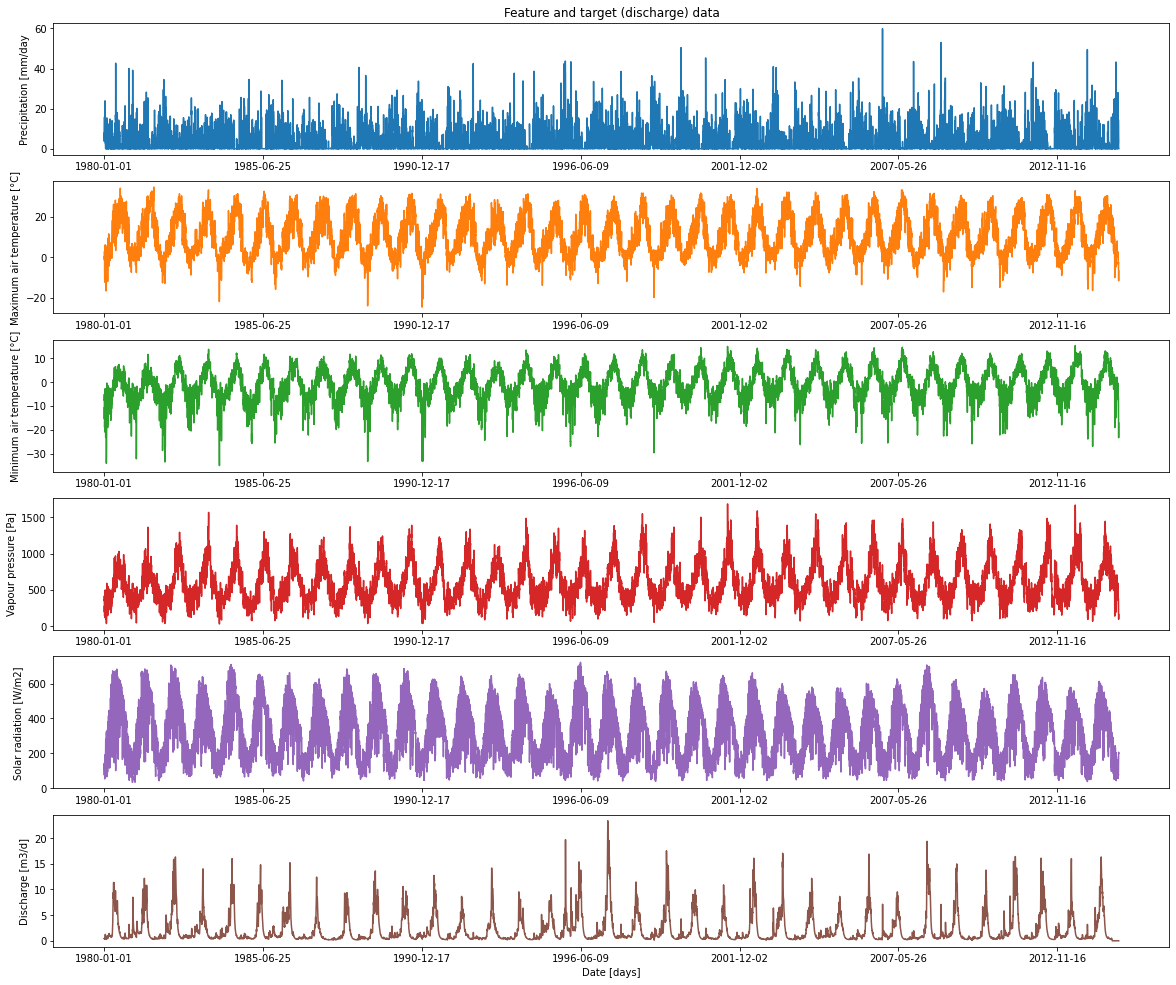

In [ ]:
# plot feature and taget data
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(20,17))
df.plot(ax=ax,subplots=True);
y_labels = ['Precipitation [mm/day', 'Maximum air temperature [°C]',
            'Minimum air temperature [°C]', 'Vapour pressure [Pa]',
            'Solar radiation [W/m2]', 'Discharge [m3/d]']
ax[0].set_title(f'Feature and target (discharge) data');
for i, iax in enumerate(ax):
    iax.set_ylabel(y_labels[i])
    iax.legend().remove()
    if iax is ax[-1]:
        iax.set_xlabel('Date [days]')
    else:
        iax.set_xlabel('')


In [ ]:
# divide dataset in training and test set
features = list(df.columns.difference([target]))
df_train = df.loc[train_start:train_end].copy()
df_test = df.loc[test_start:test_end].copy()
df_predict = df.loc[start_prediction:end_prediction].copy()

# print fraction the test set is of all the used data
print('Test set fraction: ', len(df_test) / (len(df_train) + len(df_test)))

# normalize data
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()
for col in df_train.columns:
    mean = df_train[col].mean()
    stdev = df_train[col].std()
    df_train[col] = (df_train[col] - mean) / stdev
    df_test[col] = (df_test[col] - mean) / stdev
    df_predict[col] = (df_predict[col] - mean) / stdev

Test set fraction:  0.21055667724257282


# Classes and functions to make LSTM

### Class for PyTorch dataloader

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):

        # save which are the features and target data and sequence length
        self.features = features
        self.target = target
        self.sequence_length = sequence_length

        # load data from dataframe into tensor
        y = torch.tensor(dataframe[self.target].values).float()
        X = torch.tensor(dataframe[self.features].values).float()

        # remove padding from data and save data in class
        self.y = y[sequence_length:]
        self.X = X[sequence_length:,:]

        # make extra dataseries for padding
        self.yPadding = y[:sequence_length*2]
        self.XPadding = X[:sequence_length*2,:]
        self.sequence_length = sequence_length


    def __len__(self):

        # return length shape
        return self.X.shape[0]


    def __getitem__(self, i):

        # select data from the dataset without padding and return data
        if i > self.sequence_length:
            Xr = self.X[i-self.sequence_length:i,:]
            yr = self.y[i-1]

            return Xr , yr

        # select from the padding dataset and return data
        else:
            Xr = self.XPadding[i:i+self.sequence_length,:]
            yr = self.yPadding[i+self.sequence_length - 1]

            return Xr, yr


### Images about LSTM and class for LSTM model

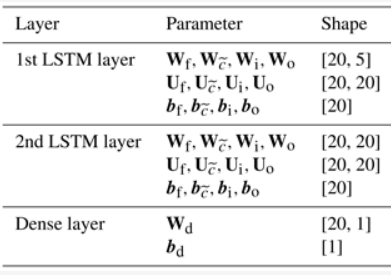

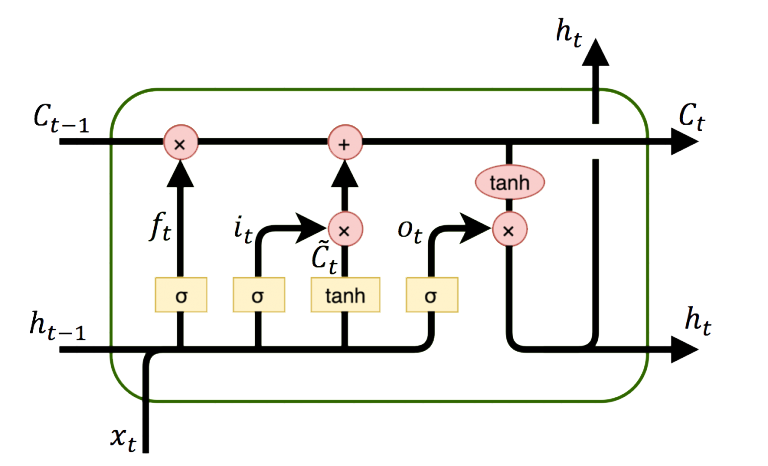

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_features, hidden_units):
        super().__init__()

        # save needed info to initialize layers
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = 1

        # first LSTM layer of model
        self.lstm1 = nn.LSTM(input_size=num_features,
                             hidden_size=hidden_units,
                             batch_first=True,
                             num_layers=self.num_layers)

        # second LSTM layer of model
        self.lstm2 = nn.LSTM(input_size=hidden_units,
                             hidden_size=hidden_units,
                             batch_first=True,
                             num_layers=self.num_layers)

        # dropout layer
        self.dropout = nn.Dropout(p=0.1)

        # linear layer
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)


    def forward(self, x):
        batch_size = x.shape[0]

        # initialize c0 and h0
        c0 = torch.zeros(self.num_layers, batch_size,
                         self.hidden_units).requires_grad_()
        h0 = torch.zeros(self.num_layers, batch_size,
                         self.hidden_units).requires_grad_()

        # load data into layers as written in the paper and return the output
        # data
        x, (_, _) = self.lstm1(x, (h0, c0))
        x = self.dropout(x)
        _, (ht,_) = self.lstm2(x, (h0, c0))
        out = self.linear(ht[0]).flatten()

        return out


### Functions to train the model, test the model and predict with the model (functions used below are from the tutorial)

In [ ]:
def train_model(data_loader, model, loss_function, optimizer):

    # initialize variables
    num_batches = len(data_loader)
    total_loss = 0

    # iterate through data from dataloader and run model and calculate loss
    model.train()
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f'Train loss: {avg_loss}')

    return avg_loss


def test_model(data_loader, model, loss_function):

    # initialize variables
    num_batches = len(data_loader)
    total_loss = 0

    # iterate through data from dataloader and test model and calculate loss
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f'Test loss: {avg_loss}')

    return avg_loss

def predict(data_loader, model):

    # initiaze output data
    output = torch.tensor([])

    # iterate through data from data loader and make prediction
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_pred = model(X)
            output = torch.cat((output, y_pred), 0)

    return output


# Make train and test datasets using the above TimeSeriesDataset class and PyTorch DataLoader class

In [ ]:
def make_model(df_train, df_test, target, features, sequence_length, batch_size,
               num_hidden_units, learning_rate):

    # make train and test dataset
    train_dataset = TimeSeriesDataset(df_train,
                                      target=target,
                                      features=features,
                                      sequence_length=sequence_length)
    test_dataset = TimeSeriesDataset(df_test,
                                    target=target,
                                    features=features,
                                    sequence_length=sequence_length)

    # load dataset in DataLoader
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)
    train_eval_loader = DataLoader(train_dataset,
                                   batch_size=batch_size,
                                   shuffle=False)

    # check if the features and targets are made accordingly with the right shapes
    # and sizes(trust us, they are)
    X, y = next(iter(train_loader))
    print('Features shape:', X.shape)
    print('Target shape:', y.shape)

    # initialize model
    model = LSTM(num_features=len(features), hidden_units=num_hidden_units)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,)

    return train_loader, test_loader, train_eval_loader, model, loss_function, optimizer

# Run model to reproduce hydrograph from paper

In [ ]:
# make model with needed objects to make prediction
train_loader, test_loader, train_eval_loader, model, loss_function, optimizer = \
    make_model(df_train, df_test, target, features, sequence_length, batch_size,
               num_hidden_units, learning_rate)

Features shape: torch.Size([512, 365, 5])
Target shape: torch.Size([512])


In [ ]:
# run untrained test
print('Untrained test\n--------')
test_loss = test_model(test_loader, model, loss_function)
test_loss_epochs = [i for i in range(1,epochs+1)]
test_loss_epochs.insert(0,'Random weigths')
print()

# add prediction with untrained test to list and define the epochs we
# want to save
test_predictions = [predict(test_loader, model).numpy()]

# # train model and calculate training and test loss
for epoch_i in range(1,epochs+1):
    print(f'Epoch {epoch_i}\n-----')

    # epoch
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)

    # predict with model if we want the prediciton of that epoch
    if epoch_i in epochs_to_save:
        test_predictions.append(predict(test_loader, model).numpy())

    print()


Untrained test
--------
Test loss: 0.9673710862795512

Epoch 1
-----
Train loss: 1.2335214972496034
Test loss: 0.7663415670394897

Epoch 2
-----
Train loss: 0.4630693197250366
Test loss: 0.28232981512943905

Epoch 3
-----
Train loss: 0.28470945209264753
Test loss: 0.1281475778669119

Epoch 4
-----
Train loss: 0.2142116829752922
Test loss: 0.10801934140423934

Epoch 5
-----
Train loss: 0.17116214483976364
Test loss: 0.10040884496023257

Epoch 6
-----
Train loss: 0.14518222361803054
Test loss: 0.08494964148849249

Epoch 7
-----
Train loss: 0.10828919857740402
Test loss: 0.060976334537069

Epoch 8
-----
Train loss: 0.08508357703685761
Test loss: 0.05528968463962277

Epoch 9
-----
Train loss: 0.07592760100960731
Test loss: 0.05127223037804166

Epoch 10
-----
Train loss: 0.06593859978020192
Test loss: 0.07028159250815709

Epoch 11
-----
Train loss: 0.07234396487474441
Test loss: 0.06075708568096161

Epoch 12
-----
Train loss: 0.06464358009397983
Test loss: 0.03511742417079707

Epoch 13
----

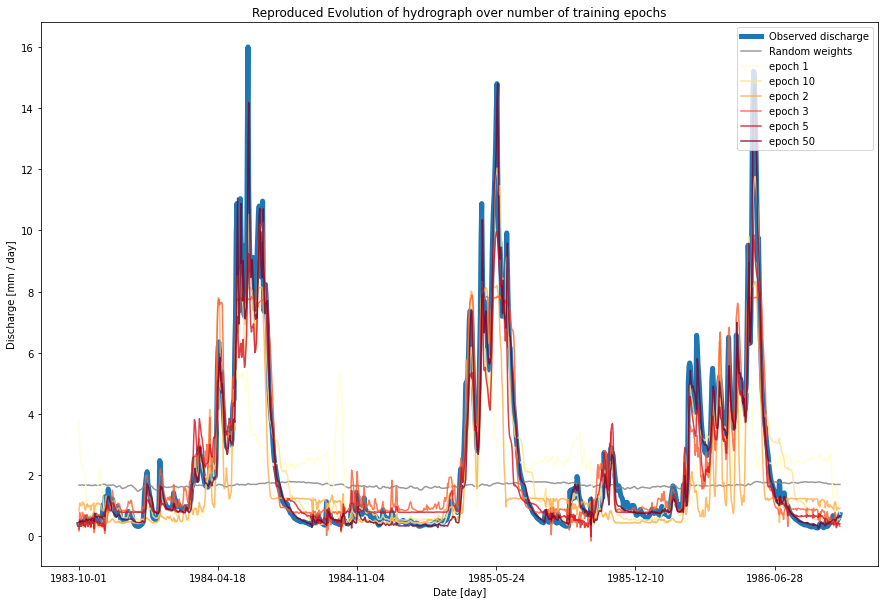

In [ ]:
# put prediction data in dataframe
epoch_list = [f'epoch {str(e)}' for e in epochs_to_save]
epoch_list.insert(0,'Random weights')
model_output_data_dict = dict(zip(epoch_list, test_predictions))

df_out = pd.DataFrame(index=df_test.index[sequence_length:], data=model_output_data_dict)
for col in df_out.columns:
    df_out[col] = df_out[col] * target_stdev + target_mean

# make sexy plot
random_weights = 'Random weights'
epoch_cols = df_out.columns.difference([random_weights])
fig,ax = plt.subplots(figsize=(15,10))
df[target][test_start:test_end].iloc[sequence_length:].plot(ax=ax, label='Observed discharge', linewidth=5)
df_out[random_weights].plot(ax=ax, alpha=0.8, color='Grey')
df_out[epoch_cols].plot(ax=ax, alpha=0.8, colormap='YlOrRd')
ax.set_xlabel('Date [day]')
ax.set_ylabel('Discharge [mm / day]')
ax.set_title('Reproduced Evolution of hydrograph over number of training epochs')
ax.legend(loc='upper right');

# Make model for a prediction and with losses

In [ ]:
# make model with needed objects to make prediction
train_loader, test_loader, train_eval_loader, model, loss_function, optimizer = \
    make_model(df_train, df_predict, target, features, sequence_length, batch_size,
               num_hidden_units, learning_rate)

Features shape: torch.Size([512, 365, 5])
Target shape: torch.Size([512])


In [ ]:
# run untrained test and make loss lists

print('Untrained test\n--------')
train_losses = []
train_loss_epochs = [i for i in range(1,epochs+1)]
test_losses = [test_model(test_loader, model, loss_function)]
test_loss_epochs = [i for i in range(0,epochs+1)]
print()

# add prediction with untrained test to list and define the epochs we
# want to save
test_predictions = [predict(test_loader, model).numpy()]

# # train model and calculate training and test loss
for epoch_i in range(1,epochs+1):
    print(f'Epoch {epoch_i}\n-----')

    # epoch
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    train_losses.append(train_loss)
    test_losses.append(test_loss)


Untrained test
--------
Test loss: 1.7973358233769734

Epoch 1
-----
Train loss: 0.9315219938755035
Test loss: 0.7982491205135981
Epoch 2
-----
Train loss: 0.3490628510713577
Test loss: 0.6484843691190084
Epoch 3
-----
Train loss: 0.33860943764448165
Test loss: 0.5851461241642634
Epoch 4
-----
Train loss: 0.2483510971069336
Test loss: 0.44912388920783997
Epoch 5
-----
Train loss: 0.17588236182928085
Test loss: 0.5870924244324366
Epoch 6
-----
Train loss: 0.14097946733236313
Test loss: 0.46100731069842976
Epoch 7
-----
Train loss: 0.10227713361382484
Test loss: 0.5342456127206484
Epoch 8
-----
Train loss: 0.07956307157874107
Test loss: 0.5356454054514567
Epoch 9
-----
Train loss: 0.08145849555730819
Test loss: 0.5461669812599818
Epoch 10
-----
Train loss: 0.0648388497531414
Test loss: 0.4525187437733014
Epoch 11
-----
Train loss: 0.05016993656754494
Test loss: 0.47019797811905545
Epoch 12
-----
Train loss: 0.04487789757549763
Test loss: 0.37120598430434865
Epoch 13
-----
Train loss: 0.0

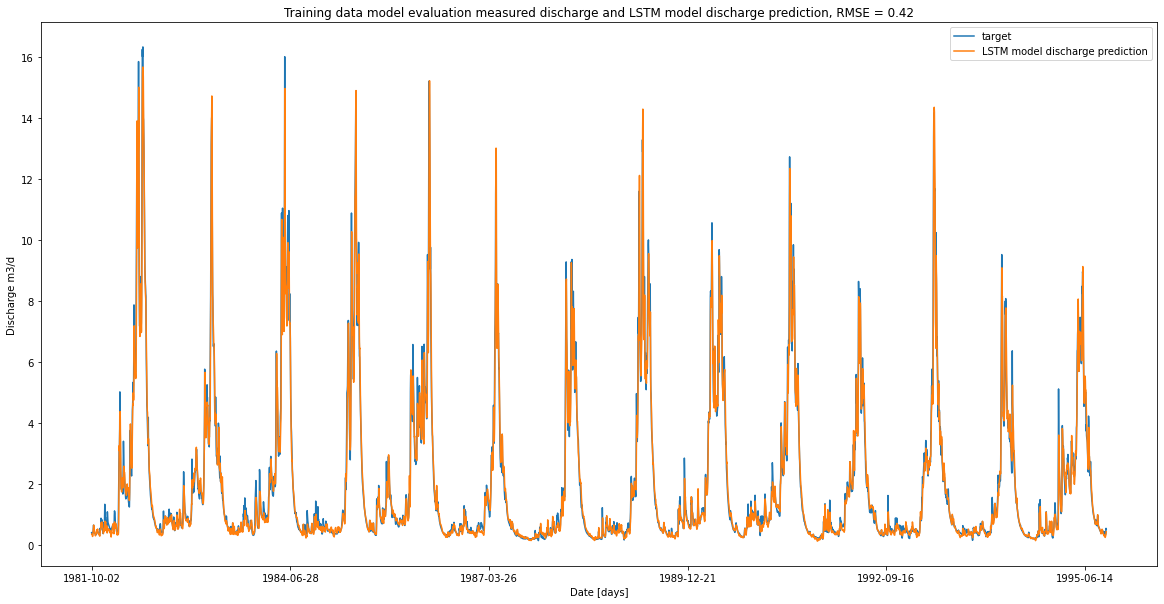

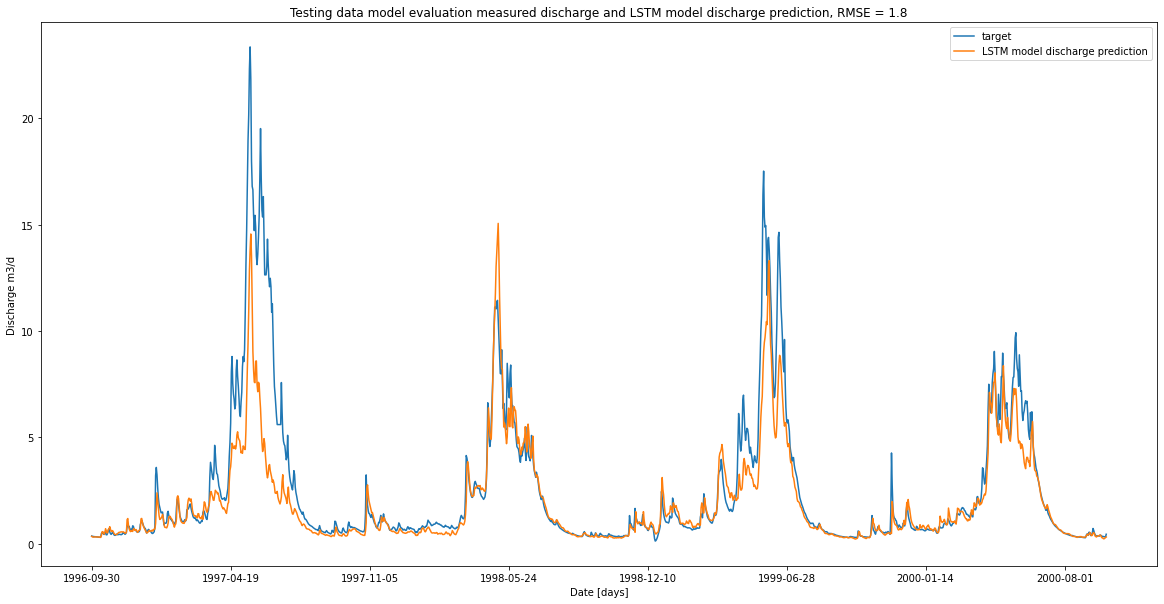

In [ ]:
# predict data with model
y_pred_train = predict(train_eval_loader, model).numpy()
y_pred_test = predict(test_loader, model).numpy()

# make placeholder for model output data
y_pred_col = 'LSTM model discharge prediction'

# load data in dataframe
df_train_out = pd.DataFrame(index=df_train.index[sequence_length:],
                        data={target:df_train[target][sequence_length:],
                              y_pred_col:y_pred_train})

df_test_out = pd.DataFrame(index=df_predict.index[sequence_length:],
                        data={target:df_predict[target][sequence_length:],
                              y_pred_col:y_pred_test})

# de-normalize data
for col in df_train_out.columns:
    df_train_out[col] = df_train_out[col] * target_stdev + target_mean

for col in df_test_out.columns:
    df_test_out[col] = df_test_out[col] * target_stdev + target_mean

# calculate RMSE for both datasets
RMSE_test = ((df_test_out[target] - df_test_out[y_pred_col]) ** 2).mean() ** .5
RMSE_train = ((df_train_out[target] - df_train_out[y_pred_col]) ** 2).mean() ** .5

# plot
fig,ax = plt.subplots(figsize=(20,10))
df_train_out.plot(ax=ax)
ax.set_ylabel('Discharge m3/d');
ax.set_xlabel('Date [days]');
ax.set_title(f'Training data model evaluation measured discharge and LSTM model discharge prediction, RMSE = {RMSE_train:.2}');
fig.show()

# plot
fig,ax = plt.subplots(figsize=(20,10))
df_test_out.plot(ax=ax)
ax.set_ylabel('Discharge m3/d');
ax.set_xlabel('Date [days]');
ax.set_title(f'Testing data model evaluation measured discharge and LSTM model discharge prediction, RMSE = {RMSE_test:.2}');
fig.show()


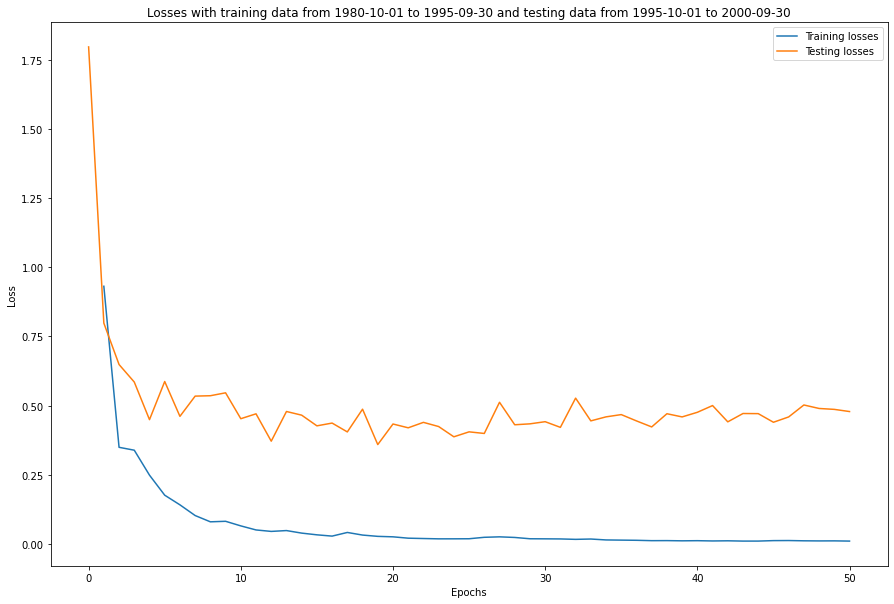

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(train_loss_epochs, train_losses, label='Training losses')
plt.plot(test_loss_epochs, test_losses, label='Testing losses')
plt.title(f'Losses with training data from {train_start} to {train_end} and testing data from {start_prediction} to {end_prediction}')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right');